In [1]:
#import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [97]:
# cargar datos
data = pd.read_csv("energy_forecasting.csv")

In [98]:
data.head(3)

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0


In [33]:
# limpiar base de datos
data = (
    data
    .assign(
        datetime = lambda k: pd.to_datetime(k.datetime, format="%Y-%m-%d %H:%M:%S"),
        year = lambda k: k.datetime.dt.year,
        month = lambda k: k.datetime.dt.month,
        day = lambda k: k.datetime.dt.day,
        hour = lambda k: k.datetime.dt.hour
    )
    .sort_values(by="datetime")
)

In [43]:
data_filtered = (
    data    
    .drop(
        ["ID", "datetime", "var2", "electricity_consumption",
         "month", "day", "year", "hour"], axis=1
    )
)

In [96]:
data_filtered.head(3)

,temperature,var1,pressure,windspeed
0,-11.4,-17.1,1003.0,571.910
1,-12.1,-19.3,996.0,575.040
2,-12.9,-20.0,1000.0,578.435


In [95]:
# varianza y media de las variables
(
    data_filtered
    .describe().T
    [["mean", "std"]]
    .assign(var = lambda k: round(k["std"]**2, 2))
    .drop("std", axis=1)
)

,mean,var
temperature,5.098989,75.39
var1,-1.916233,108.68
pressure,986.450615,144.06
windspeed,23.959956,2330.99


In [94]:
# Correlación entre las variables
data_filtered.corr()

,temperature,var1,pressure,windspeed
temperature,1.000000,0.811421,-0.723939,-0.162093
var1,0.811421,1.000000,-0.680821,-0.292305
pressure,-0.723939,-0.680821,1.000000,0.171369
windspeed,-0.162093,-0.292305,0.171369,1.000000


<Figure size 432x288 with 0 Axes>

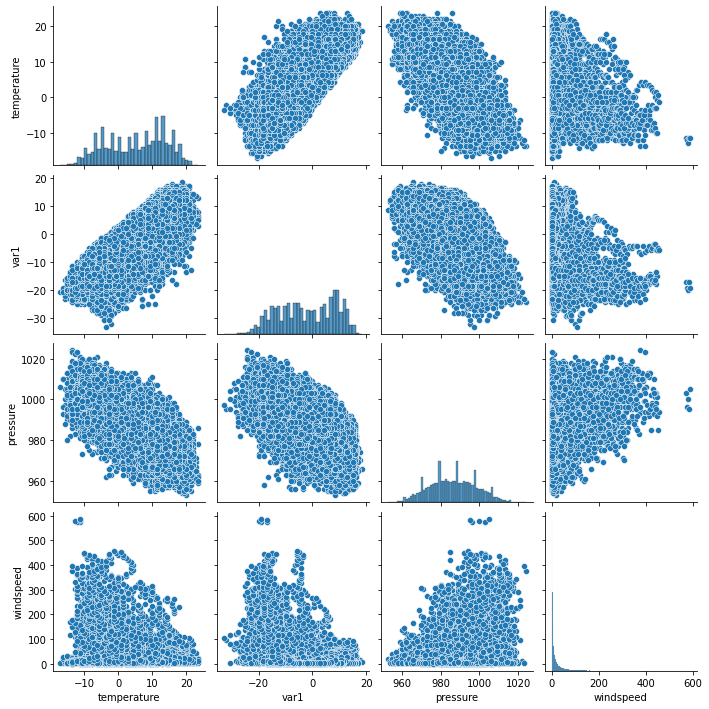

In [52]:
# Forma gráfica (pocas variables)
plt.figure()
sns.pairplot(data_filtered)
plt.show();

In [53]:
#Estandarización
scaler=StandardScaler()
scaler.fit(data_filtered)
scaled_data=pd.DataFrame(
    scaler.transform(data_filtered),
    columns=data_filtered.columns
)

In [54]:
pca=PCA()
#pca=PCA(n_components=10)
pca.fit(scaled_data)

pca_score=pd.DataFrame(data=pca.components_, columns=scaled_data.columns,)

In [93]:
# Ponderación de los componentes principales (vectores propios)
pca_score.apply(lambda k: round(k.abs(), 7))

,temperature,var1,pressure,windspeed
0,0.571961,0.574549,0.540063,0.226020
1,0.195795,0.016171,0.178900,0.964053
2,0.312780,0.484254,0.813255,0.079269
3,0.732594,0.659644,0.122241,0.115038


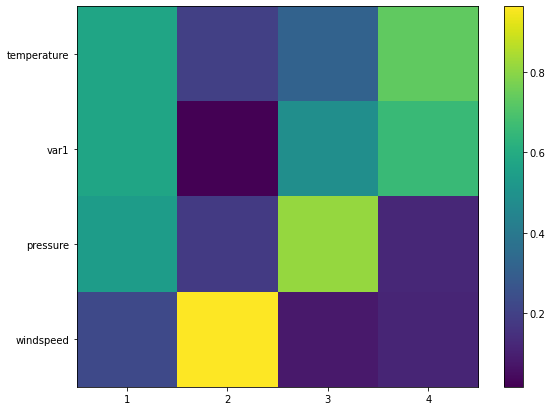

In [63]:
# Mapa de calor para visualizar in influencia de las variables
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 7))
componentes = pca.components_
plt.imshow(abs(componentes.T), cmap='viridis', aspect='auto')
plt.yticks(range(len(scaled_data.columns)), scaled_data.columns)
plt.xticks(range(len(scaled_data.columns)), np.arange(pca.n_components_)+ 1)
plt.grid(False)
plt.colorbar();

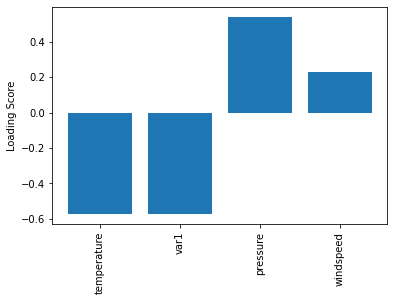

In [65]:
# Aporte al primer componente principal 
matrix_transform = pca.components_.T
plt.bar(np.arange(4),matrix_transform[:,0])
plt.xticks(range(len(scaled_data.columns)), scaled_data.columns,rotation = 90)
plt.ylabel('Loading Score')
plt.show()

In [71]:
# Pesos
loading_scores = pd.DataFrame(pca.components_[0])
#Nombre de las columnas
loading_scores.index=scaled_data.columns
# Ordena de mayor a menor los pesos
sorted_loading_scores = loading_scores[0].abs().sort_values(ascending=False)
#Selección de las 4 variables que más aportan a cada componente principal
top_4_variables= sorted_loading_scores[:4].index.values
print(top_4_variables)

['var1' 'temperature' 'pressure' 'windspeed']


In [90]:
# Nuevas variables,components principales
pca_data=pca.transform(scaled_data) 
# Forma manual de obtener los componentes princiaples
# pcas = np.dot(pca.components_, scaled_data.T)
# pcas = pd.DataFrame(pcas)
# pcas = pcas.transpose()
pd.DataFrame(pca_data)

,0,1,2,3
0,5.233582,10.299294,-0.721340,-1.568375
1,5.100625,10.446934,-0.124764,-1.566978
2,5.387783,10.435979,-0.340033,-1.557533
3,4.923564,10.631597,-0.196798,-1.675276
4,5.513598,10.559404,-0.778778,-1.443798
...,...,...,...,...
26491,2.247536,0.066451,-0.756738,0.502218
26492,2.034754,0.170306,-0.580943,0.037527
26493,1.592857,0.454092,0.103788,0.144838
26494,1.681776,0.526200,0.010642,-0.080596


In [85]:
#Porcentaje de varianza explicada por cada componente principal proporciona
per_var=np.round(pca.explained_variance_ratio_*100, decimals=1)
print("# Porcentaje de varianza acumulado de los componentes")
porcent_acum = np.cumsum(per_var)
porcent_acum

# Porcentaje de varianza acumulado de los componentes


array([ 64.1,  87.4,  95.7, 100.1])